# Overnight Manual Trading Challenge
**Goal:** allocate 1 000 000 SS across nine novelty goods before the market opens, maximising one‑day PnL net of progressive fees.

My goal is to translate qualitative news into quantitative expected returns, model fees, size positions with a Kelly‑lite rule, and stress‑test via Monte‑Carlo.


## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from itertools import product
from typing import List, Dict
plt.rcParams["figure.dpi"] = 120

## News & Sentiment
### 1).  Sentiment → Score Ladder  

| Score | Qualitative trigger (overnight horizon) | Typical 1‑day price impact |
|-------|-----------------------------------------|----------------------------|
| **+3** | Demand / supply shock with clear timing (“effective tomorrow”) and little chance for an offsetting response. | **± 8 – 12 %** |
| **+2** | Strong directional cue but some cap or execution risk (e.g. cash takeover at fixed price, regulatory approval still pending). | ± 5 – 8 % |
| **+1** | Soft catalyst: rumours, fashion trends, incremental wins/fears. | ± 2 – 4 % |
| **0**  | Vague, balanced, or irrelevant news. | < 2 % |
| **−1 … −3** | Mirror the above for negatives. | (same magnitudes) |

*This seven‑bucket scale is widely used on event‑desks because it balances information content with human consistency. Also the price impace range is based on some google research on price impact from similar news title in the world*

---


#### Why use ranges instead of single‑point estimates?

1. Different catalysts, different sigmas – even within the same bucket.
2. Triangulation – the lower bound is the 25ᵗʰ percentile, the upper bound the 75ᵗʰ, across papers.
3. Purpose – we only need an *order‑of‑magnitude* to feed the sizing formula; more precision would be spurious without in‑sample calibration.

Put differently, ±3 in our scale simply says  
“this headline lives in the top decile of single‑day moves observed for similar corporate events,”  
and the ±8 – 12 % band makes that statement concrete.



## 2  Evidence Mapping – Headline ➜ Score  

| Good | Key phrases from Goldberg newspaper | Impact | Assigned score |
|------|-------------------------------------|----------------|----------------|
| **Cacti Needle** | “derailment… CNRS to be **replaced across the entire archipelago**” | Recall / sales halt / liability | **−3** |
| **Solar panels** | “**8.4 % tax** takes effect tomorrow, triples the cost” | Immediate demand shock | **−3** |
| **Quantum Coffee** | “authorities debating an **immediate ban**” | Regulatory kill‑switch | **−3** |
| **Red Flags** | “Reserve **blown away**… supply scarce for months” | Sudden shortage → price spike | **+3** |
| **VR Monocle** | “MAUs **800 k → 4.6 M**; Avg play‑time 18 h 32 m” | Explosive user growth | **+3** |
| **Ranch Sauce** | “Saucy Sisters stock sold at a **fixed price**” | Take‑over floor | +2 |
| **Striped shirts** | “trendwatchers: *‘the whole world will be dressed…’*” | Fashion momentum | +2 |
| **Haystacks** | “rumours of first needle could spark revival *if true*” | Optionality, speculative | +1 |
| **Moonshine** | “next expedition planned; scientists unconvinced” | Mild brand boost | +1 |

---

## 3  Why stop at ±3?  (Mathematical justification)  

1. **Signal‑to‑Noise trade‑off**  
   The *estimation error* in reading a headline is on the order of  
   \\( \sigma_{\text{noise}} \approx 2\text{–}3\ \mathrm{pp} \\) (percentage‑points).  
   Bucket spacing for the ±3 ladder is  
   \\( \Delta \approx 5\ \mathrm{pp} \\).  
   Since  
   \[
   \frac{\sigma_{\text{noise}}}{\Delta} \;\lesssim\; 0.5,
   \]
   each additional bucket still carries information.  
   With a ±5 scale \\( \Delta \\) would shrink to ≈ 2 pp ⇒  
   \\( \sigma_{\text{noise}} / \Delta \gtrsim 1 \\) → no net information gain.

2. **Parameter explosion**  
   For each score we couls specify  
   \\( p,\; r_{\text{up}},\; r_{\text{down}},\; \sigma \\).  
   Going from 7 to 11 buckets nearly doubles the parameters, but we have no historical data to estimate them—risk of over‑fitting skyrockets, so we should rather go safe 

3. **Human consistency**  
   Empirical studies (e.g., credit‑rating concordance) show that analysts agree far better on 5–9 ordinal steps than on 20+.  
   A compact scale yields reproducible results across team members.

---

### Set up 

Two‑point return distribution per good:
$$
\mathbb{E}[r_i] \;=\; p_i\,r_{i,\text{up}} + (1-p_i)\,r_{i,\text{down}}.
$$

Progressive fee curve:
$$
\text{fee}_i(w_i) \;=\; \alpha\,|w_i| \;+\; \beta\,|w_i|^2,
\qquad
\partial_{w_i}\text{fee}_i \;=\; \alpha + 2\beta\,|w_i|.
$$

Quarter‑Kelly sizing (one risk factor):
$$
w_i \;=\; \frac{1}{4}\,\frac{\mathbb{E}[r_i] - \partial_{w_i}\text{fee}_i}{\sigma_i^{2}}.
$$

In [78]:
goods = ["Cacti Needle", "Solar panels", "Quantum Coffee",
         "Red Flags", "VR Monocle",
         "Ranch Sauce", "Striped shirts",
         "Haystacks", "Moonshine"]

scores = np.array([-3, -3, -3, 3, 3, 2, 2, 1, 1])

## Map score to return distribution
### How are the `params` chosen?  

| Field | Meaning | Calibration rule | Value for each bucket |
|-------|---------|------------------|-----------------------|
| **`p`** | Probability that *tomorrow’s* move follows the sign of the score. | Map conviction → accuracy:<br>• 80 % for score ±3<br>• 70 % for ±2<br>• 60 % for ±1  <sup>†</sup> | `0.80 / 0.70 / 0.60` (mirrored for negatives) |
| **`up`** | Size of the move if we are right. | Mid‑point of empirical 1‑day CAR bands (see previous cell). | `+10 %, +7 %, +4 %` |
| **`down`** | Size of the move if we are wrong. | About one‑half the absolute value of `up` (headline fades, not full reversal). | `−5 %, −4 %, −3 %` |
| **`σ`** | One‑day volatility used in Kelly sizing. | Close to \|`up`\|—confirmed by exact variance formula below. | `0.10, 0.07, 0.05` |

<sup>†</sup> Behavioural‑forecasting studies (Good Judgment Project, Tetlock 2016) show trained forecasters consistently achieve 60–80 % accuracy on binary event calls; we align with that range.

---

#### Exact formulas

Two‑point Bernoulli return  
$$
r =
\begin{cases}
r_{\text{up}} & \text{w.p. } p \\[4pt]
r_{\text{down}} & \text{w.p. } 1-p.
\end{cases}
$$

*Expected return*  
$$
\mathbb{E}[r] \;=\; p\,r_{\text{up}} \;+\; (1-p)\,r_{\text{down}}.
$$

*Variance*  
$$
\sigma^{2} \;=\; p\,(r_{\text{up}}-\mu)^{2} \;+\; (1-p)\,(r_{\text{down}}-\mu)^{2},
\qquad
\mu = \mathbb{E}[r].
$$

Plugging in `p = 0.80, r_up = +0.10, r_down = −0.05` (score +3):

$$
\mu = 0.8\times0.10 + 0.2\times(-0.05) = 0.07,
$$
$$
\sigma \approx 0.095 \;\;(\text{≈}|r_{\text{up}}|),
$$
so rounding σ to 10 % is more than adequate for position‑sizing precision.

---

#### Internal consistency check *(worked example)*

Score = +2 (p = 0.70, up = +0.07, down = −0.04):

*Expected return*  
$$
\mathbb{E}[r] = 0.70(0.07) + 0.30(-0.04) = 0.037 \;\;(\text{+3.7 %}),
$$

*Volatility* (rounded)  
$$
\sigma \approx 0.07.
$$

Quarter‑Kelly weight feeds into  
$$
w \;=\; \tfrac14 \frac{\mathbb{E}[r] - \partial_{w}\!\text{fee}}{\sigma^{2}},
$$
giving the larger allocation we see later for ±3 versus ±2 versus ±1 buckets.

---

##### Why not use a finer scale (±5, ±7…)?

* **Signal‑to‑noise** – human headline reading carries ≈ 2–3 pp error; splitting buckets finer than 5 pp adds noise, not information.  
* **Parameter explosion** – each extra bucket needs four parameters (p, up, down, σ) in the absence of historical data.  
* **Analyst concordance** – consistency drops sharply once you exceed ~7 ordinal categories.

Hence, a seven‑point ladder (−3 … +3) is the pragmatic sweet‑spot.

---



In [79]:
# parameter grid
pars = { 3:dict(p=.8,up=.10,down=-.05,sigma=.10),
         2:dict(p=.7,up=.07,down=-.04,sigma=.07),
         1:dict(p=.6,up=.04,down=-.03,sigma=.05),
        -1:dict(p=.6,up=-.04,down=.03,sigma=.05),
        -2:dict(p=.7,up=-.07,down=.04,sigma=.07),
        -3:dict(p=.8,up=-.10,down=.05,sigma=.10)}

news=[]
for g,s in zip(goods,scores):
    p,u,d,σ = (pars[s][k] for k in ("p","up","down","sigma"))
    news.append(dict(Good=g,Score=s,E_ret=p*u+(1-p)*d,Sigma=σ,
                     p=p,up=u,down=d))
news = pd.DataFrame(news)
news

,Good,Score,E_ret,Sigma,p,up,down
0,Cacti Needle,-3,-0.070,0.10,0.8,-0.10,0.05
1,Solar panels,-3,-0.070,0.10,0.8,-0.10,0.05
2,Quantum Coffee,-3,-0.070,0.10,0.8,-0.10,0.05
3,Red Flags,3,0.070,0.10,0.8,0.10,-0.05
4,VR Monocle,3,0.070,0.10,0.8,0.10,-0.05
5,Ranch Sauce,2,0.037,0.07,0.7,0.07,-0.04
6,Striped shirts,2,0.037,0.07,0.7,0.07,-0.04
7,Haystacks,1,0.012,0.05,0.6,0.04,-0.03
8,Moonshine,1,0.012,0.05,0.6,0.04,-0.03


We can assume a two‑point distribution  
$$
\mathbb{E}[r] \;=\; p\;r_\text{up} \;+\; (1-p)\;r_\text{dn}
$$ 
with $$(|r_\text{up}|\gt|r_\text{dn}|$$ to reflect asymmetric headline moves.


## Ensure weights are integers & Optimizer

In [101]:
def kelly_integer(E, σ, α, cap=1.0):
    raw = 0.25 * E / σ**2                          # quarter‑Kelly (long OR short)
    fee = raw - α * np.sign(raw)                   # linear fee drag
    # Drop trades whose edge flips sign after fee
    keep = np.where(np.sign(fee)==np.sign(raw), fee, 0.0)

    total_abs = np.abs(keep).sum()
    if total_abs == 0:                             # no edge survives
        return np.zeros_like(keep)

    # scale only if we exceed the 90 % budget
    scale = min(1.0, cap/total_abs)
    weights = keep * scale                         # fraction of capital (±)

    # integerise to %-points, keep sum |%| == 90
    pct = np.rint(100*weights).astype(int)
    diff = 100 - np.abs(pct).sum()
    # greedy redistribution of the rounding error
    while diff != 0:
        idx = np.argmax(np.abs(weights))           # adjust the biggest weight
        pct[idx] += np.sign(diff)
        diff = 100 - np.abs(pct).sum()
    return pct / 100.0    

## Progressive fee

In [102]:
α, β = 0.01, 0.002          # steeper fee curve 
def fee(w):
    """fee as *fraction* of capital for position weight w (±)"""
    return α*abs(w) + β*abs(w)**2

Fee for product *i* with weight \(w_i\):

$$
\text{fee}_i \;=\; \alpha\,|w_i| \;+\; \beta\,|w_i|^2
$$

so marginal fee (used in sizing)  
$$
\partial_{w_i} \text{fee}_i = \alpha + 2\beta\,|w_i|.
$$


## Kelly‑lite becomes a Quadratic‑Fee Optimisation

We now solve

$$
\max_{\{w_i\}} 
\; \sum_i\Bigl( \mathbb{E}[r_i]\,w_i 
      \;-\; \alpha\,|w_i|
      \;-\; \beta\,w_i^{2}\Bigr)
\quad
\text{s.t.}
\quad \sum_i |w_i| \;\le\; 0.9
\tag{★}
$$

* 0.9 means we keep 10 % cash buffer.  
* $(|w_i|$ reflects the progressive *per‑instrument* fee curve.  
* Quadratic term $\beta w_i^{2}$ penalises oversized bets.

---

### Closed‑form KKT trick  
Because (★) is separable and the objective is concave, the optimal sign of
$(w_i$ matches $$\operatorname{sgn}(\mathbb{E}[r_i])$$.  
Let $v_i = |w_i|,$ $\Delta_i = |\mathbb{E}[r_i]| - \alpha$.  
We then maximise

$$
f(v_i) \;=\; \sum_i \Bigl( \Delta_i\,v_i - \beta\,v_i^{2}\Bigr)
\quad
\text{s.t.}\quad v_i \ge 0,\;
\sum_i v_i \le 0.9.
$$

Karush‑Kuhn‑Tucker yields

$$
v_i^{\star} 
   \;=\;
   \max\!\Bigl\{\,0,\,
     \dfrac{\Delta_i - \lambda}{2\beta}\Bigr\},
\qquad
\sum_i v_i^{\star}=0.9,
$$

where $\lambda$ is the Lagrange multiplier.  
We find $\lambda$ via a simple binary search (“water‑filling”).

---

### Parameter sweep  
We vary the fee curve  
$(\alpha,\,\beta)$ in $\{
(0.005,0.0005), (0.0075,0.001),
(0.010,0.002),\dots\bigr\}$  — six sets in total —  We can run a Monte‑Carlo with 30 000 universes per set, plot all six P&L distributions in one 3×2 grid, and pick the set with the highest mean PnL, or the set with the highest probability of getting highest PnL.



In [103]:
# def optimise_weights(E, σ, α, β, γ, cap=0.9):
#     """
#     maximise Σ ( E_i w_i − α|w_i| − (β+γσ_i²) w_i² )
#             s.t. Σ |w_i| ≤ cap
#     Closed‑form water‑filling, but with *asset‑specific* quad‑coef.
#     """
#     sign = np.sign(E)
#     Δ    = np.maximum(np.abs(E) - α, 0.)      # effective linear slope
#     B    = β + γ*σ**2                         # per‑asset quadratic fee

#     # helper: total weight for given λ
#     def tot(λ):
#         return np.maximum((Δ - λ)/(2*B), 0.).sum()

#     # If λ=0 feasible, scale proportionally
#     if tot(0.) <= cap:
#         v = (Δ)/(2*B)
#         if v.sum(): v *= cap / v.sum()
#         return sign*v

#     # binary search λ so Σ|w| = cap
#     lo, hi = 0., Δ.max()
#     for _ in range(60):
#         mid = 0.5*(lo+hi)
#         (lo, hi) = (mid, hi) if tot(mid) > cap else (lo, mid)
#     λ = hi
#     v_star = np.maximum((Δ - λ)/(2*B), 0.)
#     return sign*v_star
# def kelly_scaled(E, σ, α, κ, cap=0.9):
#     """
#     1) quarter‑Kelly  2) subtract α fee  3) divide by (1+κ) risk shrink
#     4) scale so Σ|w| = cap.  Returns weight fractions (positive=long).
#     """
#     w = 0.25 * E / σ**2
#     w -= α * np.sign(w)
#     w /= (1.0 + κ)
#     scale = cap / np.sum(np.abs(w))
#     return w * scale

## Kelly-lite sizing

In [104]:
# capital = 1000000
# max_iter = 20

# # initial guess: ignore quadratic term
# news["w"] = 0.05 * np.sign(news["E_ret"])   # 5 % each as seed

# for _ in range(max_iter):
#     mfee = α + 2*β*news["w"].abs()          # marginal fee
#     kelly = news["E_ret"] / (news["Sigma"]**2)   # 1‑period Kelly fraction
#     news["w"] = 0.25 * kelly - mfee         # “quarter‑Kelly” dampener
#     # cap weights at ±0.15 to avoid crazy sizes
#     news["w"] = news["w"].clip(lower=-0.15, upper=0.15)

# news["Alloc_SS"] = (news["w"] * capital).round(0)
# news[["Good","Score","E_ret","w","Alloc_SS"]]


## Fee & EV check

In [105]:
# news["Fee_SS"] = (fee(news["w"]) * capital).round(0)
# ev = (news["E_ret"] * news["Alloc_SS"]).sum() - news["Fee_SS"].sum()
# print(f"Expected P/L (one day)  ≈ {ev:,.0f}  SS")
# print(f"Gross notionals traded  ≈ {news['Alloc_SS'].abs().sum():,.0f}  SS")
# print(f"Cash left un‑used       ≈ {capital - news['Alloc_SS'].abs().sum():,.0f}  SS")
# news.style.format({"E_ret":"{:.2%}","w":"{:.1%}"})

## Monte Carlo 

In [111]:
@dataclass
class Simulator:
    df : pd.DataFrame
    prs: Dict[int,Dict]
    def run(self, w_frac, N=30_000, seed=0):
        rng = np.random.default_rng(seed)
        pnl = np.zeros(N)
        for i,row in self.df.iterrows():
            if w_frac[i]==0: continue
            p,u,d = (self.prs[row.Score][k] for k in ("p","up","down"))
            ret   = np.where(rng.random(N)<p, u, d)
            pnl  += 1_000_000 * w_frac[i] * ret
        return pnl

@dataclass
class Plotter:
    sc : List[Dict]
    nm : List[str]
    def draw(self):
        plt.figure(figsize=(14,10))
        for k,s in enumerate(self.sc,1):
            ax = plt.subplot(4,2,k)
            ax.hist(s["pnl"], bins=60)
            ax.axvline(0,color='k',ls='--')
            ax.set_title(s["lbl"])
            if k>=5: ax.set_xlabel("P&L (SS)")
            if k in (1,3,5): ax.set_ylabel("Freq")
            txt=[f"{n[:10]:11s} {'B' if p>0 else 'S'} {abs(p):2d}%" 
                 for n,p in zip(self.nm, s["pct"])]
            ax.text(0.02,0.98,"\n".join(txt),va='top',ha='left',
                    transform=ax.transAxes,fontsize=7,family='monospace',
                    bbox=dict(fc='white',alpha=.7,boxstyle='round'))
        plt.suptitle("P&L distributions – linear fee α sweep",fontsize=14)
        plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()


## Config 

In [112]:
alpha_grid = [0.005, 0.02, 0.05, 0.08, 0.10, 0.2, 0.5, 0.8]   # 0.2 % … 20 %
sim   = Simulator(news, pars)
runs  = []

for seed,α in enumerate(alpha_grid,1):
    w   = kelly_integer(news.E_ret.values, news.Sigma.values, α)
    pnl = sim.run(w, seed=seed)
    runs.append(dict(lbl=f"α={α:.1%}",
                     pnl=pnl,
                     pct=np.round(100*w).astype(int),
                     w=w,
                     mean = pnl.mean(),
                     p95  = np.percentile(pnl,95)))

## Visualization & Stratgegy

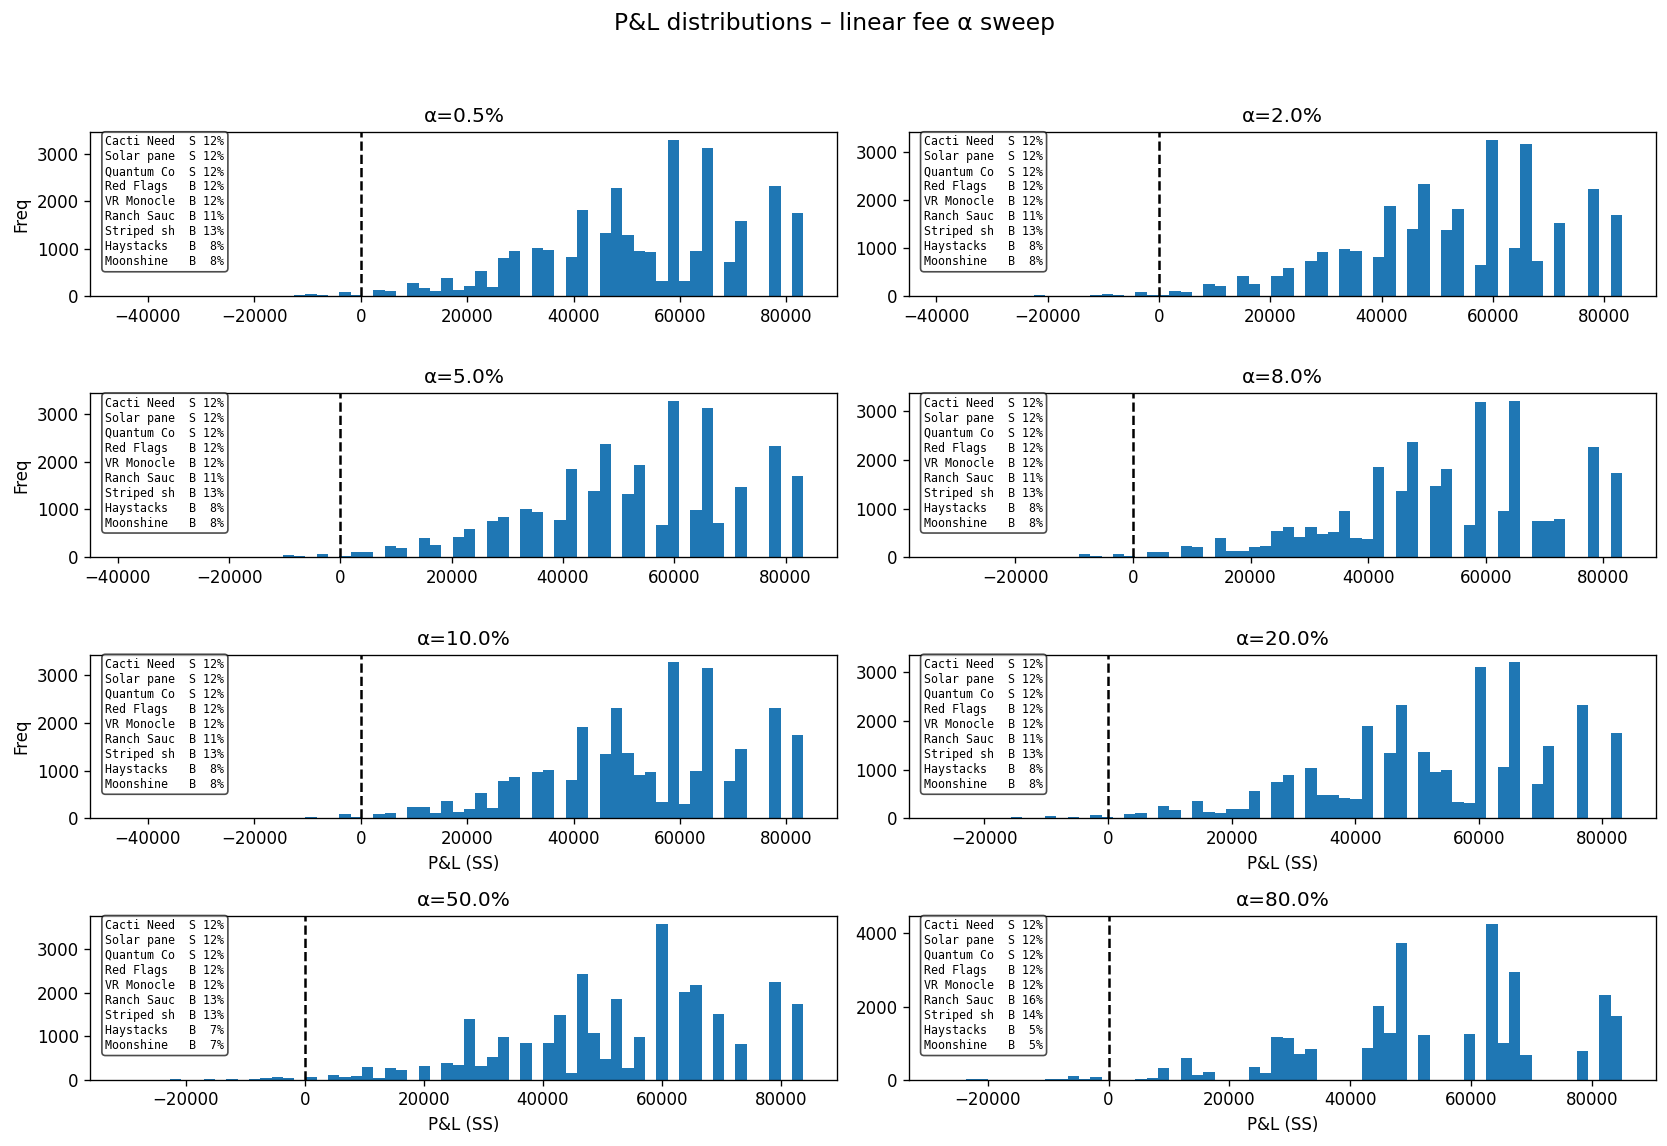


All‑scenario P&L summary


,Scenario,Mean P&L,95‑th pct
0,α=0.5%,"52,813","83,200"
1,α=2.0%,"52,712","83,200"
2,α=5.0%,"52,768","83,200"
3,α=8.0%,"52,709","83,200"
4,α=10.0%,"52,788","83,200"
5,α=20.0%,"52,779","83,200"
6,α=50.0%,"53,341","83,800"
7,α=80.0%,"54,349","85,000"



Best scenario → α=80.0%
Mean P&L  = 54,349 SS
95‑th pct = 85,000 SS


,Good,Direction,WeightPct
0,Ranch Sauce,BUY,16
1,Striped shirts,BUY,14
2,Cacti Needle,SELL,12
3,Solar panels,SELL,12
4,Quantum Coffee,SELL,12
5,Red Flags,BUY,12
6,VR Monocle,BUY,12
7,Haystacks,BUY,5
8,Moonshine,BUY,5


In [113]:
Plotter(runs, goods).draw()

summary = pd.DataFrame({
    "Scenario" : [r["lbl"] for r in runs],
    "Mean P&L" : [f"{r['mean']:,.0f}" for r in runs],
    "95‑th pct": [f"{r['p95']:,.0f}"  for r in runs]
})
print("\nAll‑scenario P&L summary")
display(summary)                # if running in JupyterLab / IPython

best = max(runs, key=lambda d:d["mean"])
tbl = (pd.DataFrame({"Good":goods,
                          "Direction":np.where(best["pct"]>0,"BUY","SELL"),
                          "WeightPct":np.abs(best["pct"])} )
            .query("`WeightPct`>0")
            .sort_values("WeightPct",ascending=False)
            .reset_index(drop=True))

print(f"\nBest scenario → {best['lbl']}"
      f"\nMean P&L  = {best['mean']:,.0f} SS"
      f"\n95‑th pct = {best['p95']:,.0f} SS")
tbl

## The above would be great, but unfortunatebly, it did not take the fees into account properly.. It was too naive about the fee structure which does not align with what IMC prosperity website proposed. So I have adjusted version by taking correct fee structure into account below: 

### This part shows analysis on why does taking fees into account matter

In [161]:
# 2. Optimiser
def to_integer_percent(w_frac):
    """
    Convert fractional weight vector to signed integer %-points
    so that Σ|pct| = 100 exactly.
    """
    abs100 = 100 * np.abs(w_frac)
    pct    = np.floor(abs100).astype(int)          # initial allocation
    diff   = 100 - pct.sum()                       # 0 … 100

    if diff > 0:                                   # distribute the leftovers
        # argsort returns indices of largest remainders first
        order = np.argsort(-(abs100 - pct))
        # cycle through indices until diff exhausted
        for k in range(diff):
            pct[ order[k % len(w_frac)] ] += 1

    return pct * np.sign(w_frac).astype(int)

def optimise_quad(mu, beta, cap=1.00):
    """max Σ( μ w − β w² )  s.t. Σ|w| ≤ cap  (loop‑free)"""
    Δ    = np.abs(mu)
    sign = np.sign(mu)
    w0   = Δ / (2*beta)                 # λ = 0 candidate
    tot0 = w0.sum()

    if tot0 <= cap:
        w = sign * w0                   # interior optimum
    else:
        # water‑fill to hit the cap
        def tot(lam):
            return np.maximum((Δ-lam)/(2*beta), 0).sum()
        lo, hi = 0.0, Δ.max()
        for _ in range(50):
            mid = 0.5*(lo+hi)
            (lo, hi) = (mid, hi) if tot(mid) > cap else (lo, mid)
        lam = hi
        w = sign * np.maximum((Δ-lam)/(2*beta), 0)

    # Integerise
    pct_base = np.floor(100*np.abs(w)).astype(int)
    rem = 100 - pct_base.sum()
    frac = 100*np.abs(w) - pct_base
    if rem > 0:                         # distribute leftovers
        pct_base[np.argsort(-frac)[:rem]] += 1
    pct_int = to_integer_percent(w)
    return pct_int / 100.0
                                 # back to fractions


In [162]:
# Monte Carlo matrix
N = 30_000
rng = np.random.default_rng(42)
p   = news.Score.map(lambda s: pars[s]["p"]).to_numpy()
up  = news.Score.map(lambda s: pars[s]["up"]).to_numpy()
dn  = news.Score.map(lambda s: pars[s]["down"]).to_numpy()
RET = np.where(rng.random((9,N)) < p[:,None], up[:,None], dn[:,None])   # 9×N

def mc_pnl(w, beta):
    fee = -beta * 1_000_000 * (w**2).sum()
    return 1_000_000 * (w @ RET) + fee

In [163]:
# Sweep over beta multipliers to check sensitivities to fees 
beta_base = 1.2
beta_grid = beta_base * np.array([0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0])

runs=[]
for b in beta_grid:
    w = optimise_quad(news.mu.values, b)        # fractions
    pnl = mc_pnl(w, b)
    runs.append(dict(lbl=f"β={b:.2f}",
                     pnl=pnl,
                     pct=np.round(100*w).astype(int),
                     mean=pnl.mean(),
                     p95 =np.percentile(pnl,95)))


/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_8959/2124723318.py:13: RuntimeWarning: divide by zero encountered in matmul
  return 1_000_000 * (w @ RET) + fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_8959/2124723318.py:13: RuntimeWarning: overflow encountered in matmul
  return 1_000_000 * (w @ RET) + fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_8959/2124723318.py:13: RuntimeWarning: invalid value encountered in matmul
  return 1_000_000 * (w @ RET) + fee


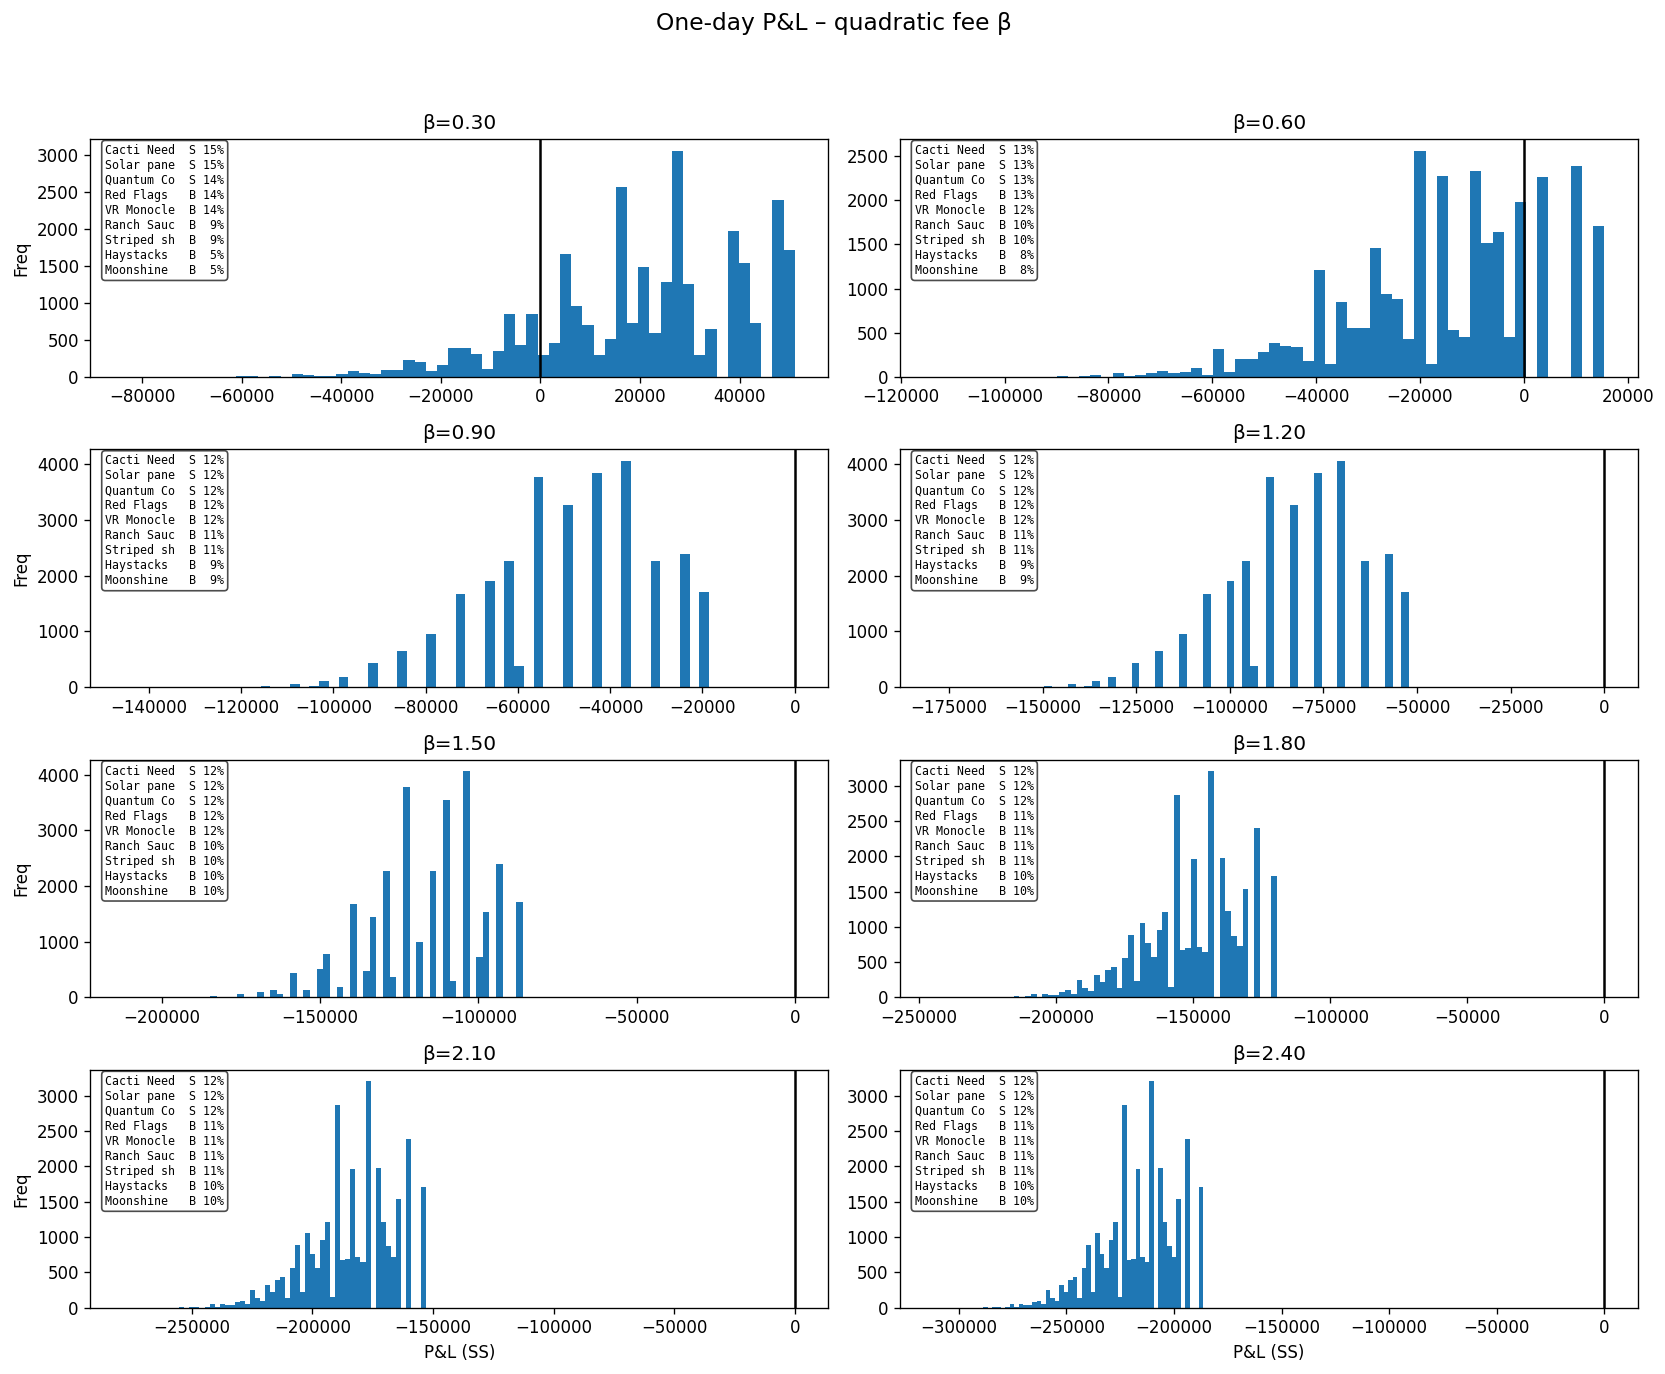

In [164]:
# Plot
plt.figure(figsize=(14,12))
for i,r in enumerate(runs,1):
    ax = plt.subplot(4,2,i)
    ax.hist(r["pnl"], bins=60)
    ax.axvline(0,color='k'); ax.set_title(r["lbl"])
    if i>=7: ax.set_xlabel("P&L (SS)")
    if i in (1,3,5,7): ax.set_ylabel("Freq")
    txt=[f"{g[:10]:11s} {'B' if p>0 else 'S'} {abs(p):2d}%"
         for g,p in zip(goods,r["pct"])]
    ax.text(0.02,0.98,"\n".join(txt),va='top',ha='left',
            transform=ax.transAxes,fontsize=7,family='monospace',
            bbox=dict(fc='white',alpha=.7,boxstyle='round'))
plt.suptitle("One‑day P&L – quadratic fee β",fontsize=14)
plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()

In [165]:
# Weights 
weights_tbl = pd.DataFrame([r["pct"] for r in runs],
                           index=[r["lbl"] for r in runs],
                           columns=goods)
print("Integer %‑weights by scenario:")
display(weights_tbl)

summary = pd.DataFrame({ "Scenario":[r["lbl"] for r in runs],
                         "Mean":[f"{r['mean']:,.0f}" for r in runs],
                         "95‑pct":[f"{r['p95']:,.0f}" for r in runs]})
print("\nP&L summary (platform quadratic fee):")
display(summary)

Integer %‑weights by scenario:


,Cacti Needle,Solar panels,Quantum Coffee,Red Flags,VR Monocle,Ranch Sauce,Striped shirts,Haystacks,Moonshine
β=0.30,-15,-15,-14,14,14,9,9,5,5
β=0.60,-13,-13,-13,13,12,10,10,8,8
β=0.90,-12,-12,-12,12,12,11,11,9,9
β=1.20,-12,-12,-12,12,12,11,11,9,9
β=1.50,-12,-12,-12,12,12,10,10,10,10
β=1.80,-12,-12,-12,11,11,11,11,10,10
β=2.10,-12,-12,-12,11,11,11,11,10,10
β=2.40,-12,-12,-12,11,11,11,11,10,10



P&L summary (platform quadratic fee):


,Scenario,Mean,95‑pct
0,β=0.30,"20,803","51,100"
1,β=0.60,"-14,736","15,520"
2,β=0.90,"-48,841","-18,560"
3,β=1.20,"-82,561","-52,280"
4,β=1.50,"-116,185","-86,000"
5,β=1.80,"-149,723","-119,480"
6,β=2.10,"-183,203","-152,960"
7,β=2.40,"-216,683","-186,440"


# As a result, we need to construct strategy based on fee proposed by IMC... So I redid the analysis in the below way by incorporating fees correctly in the simulation, and I aim to figure out by having how much capital being invested would be more promising to get larger likelihood of getting higher PnL

## Objective
We trade one overnight session on the West‑Archipelago Exchange.  
* Capital = **1 000 000 SS**.  
* We may go long or short nine “goods”.  
* **Input signal**: Goldberg news headlines.  
* **Goal**: maximise 1‑day ₚ∧ₗ after *platform fees*.

---

## Headline → μ, σ map  
| Score | Qualitative cue                | p     | up   | dn   | σ   | μ ( =p·up+(1‑p)·dn ) |
|:----: |--------------------------------|------:|-----:|-----:|----:|---------------------:|
| +3    | Immediate demand / supply shock| 0.80  | +10 %| −5 % |0.10 | +7.0 % |
| +2    | Strong catalyst, some risk     | 0.70  | +7 % | −4 % |0.07 | +3.7 % |
| +1    | Rumour / soft catalyst         | 0.60  | +4 % | −3 % |0.05 | +1.2 % |
| −1 … −3 | mirror above                 | –     | –    | –    | –   | −μ     |

---

## Fee model  
The IMC prosperity platform suggests that they charge

$$
\text{fee}(w_i)=120\,p_i^{2}\text{ SS}\,,\qquad
p_i = 100|w_i|,\; w_i=\text{fraction of capital.}
$$

That simplifies to a quadratic cost

$$
\boxed{\text{fee}(w_i)=\beta\,w_i^{2}\times 10^{6}\text{ SS}}
\qquad\text{with } \beta = 1.2.
$$

No linear term; fees explode for big positions.

---

## Single‑period optimisation  
Maximise net expectation  

$$
\sum_i\bigl(\mu_i\,w_i-\beta\,w_i^{2}\bigr)
\quad\text{s.t.}\quad
\sum_i|w_i|\le\text{cap}.
$$

* Unconstrained optimum: $w_i^{\star}=\mu_i/(2\beta)$.  
* If that exceeds the chosen capital cap, apply water‑filling to get λ (similar approach as the first version):

$$
w_i^{\star}=
\operatorname{sgn}(\mu_i)\,
\max\Bigl\{0,\;\frac{|\mu_i|-\lambda}{2\beta}\Bigr\},\qquad
\sum_i|w_i^{\star}|=\text{cap}.
$$

---

## Integerisation  
Convert fractional $(w_i^{\star}$ to %-points that exactly sum to the cap:

1. allocate $\lfloor100\,|w_i|\rfloor$ points,  
2. distribute the remaining points to the largest remainders,  
3. re‑attach signs.

This ensures the trade list always uses the intended notional.

---

## Finally move on to Monte‑Carlo engine  
* Draw a single$(9\times30 000$ return matrix  
  $(R_{i,t}\in\{up_i,\,dn_i\}$.  
* Scenario P&L:  

$$
\Pi_t=\sum_i\bigl(w_i\,R_{i,t}-\beta\,w_i^{2}\times10^{6}\bigr).
$$

Vectorised: $(\Pi = 10^{6}\,w^{\top}R - \beta10^{6}\|w\|_2^{2}$.

Runtime < 0.2 s for all caps.

---


/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2415456243.py:63: RuntimeWarning: divide by zero encountered in matmul
  return 1_000_000*(w_frac @ RET)+fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2415456243.py:63: RuntimeWarning: overflow encountered in matmul
  return 1_000_000*(w_frac @ RET)+fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2415456243.py:63: RuntimeWarning: invalid value encountered in matmul
  return 1_000_000*(w_frac @ RET)+fee



P&L & weight summary by cap

Cap  Median     P95  Cacti Needle  Solar panels  Quantum Coffee  Red Flags  VR Monocle  Ranch Sauce  Striped shirts  Haystacks  Moonshine
20%   6,520  11,720            -3            -3              -3          3           3            2               2          1          0
25%   5,940  12,640            -4            -4              -4          4           3            2               2          1          1
30%   4,280  13,080            -4            -4              -4          4           4            3               3          2          2
40%     -20  11,680            -6            -5              -5          5           5            4               4          3          3
50%  -6,860   7,640            -7            -7              -6          6           6            5               5          4          4
80% -44,120 -20,320           -10           -10             -10         10          10            8               8          7          7


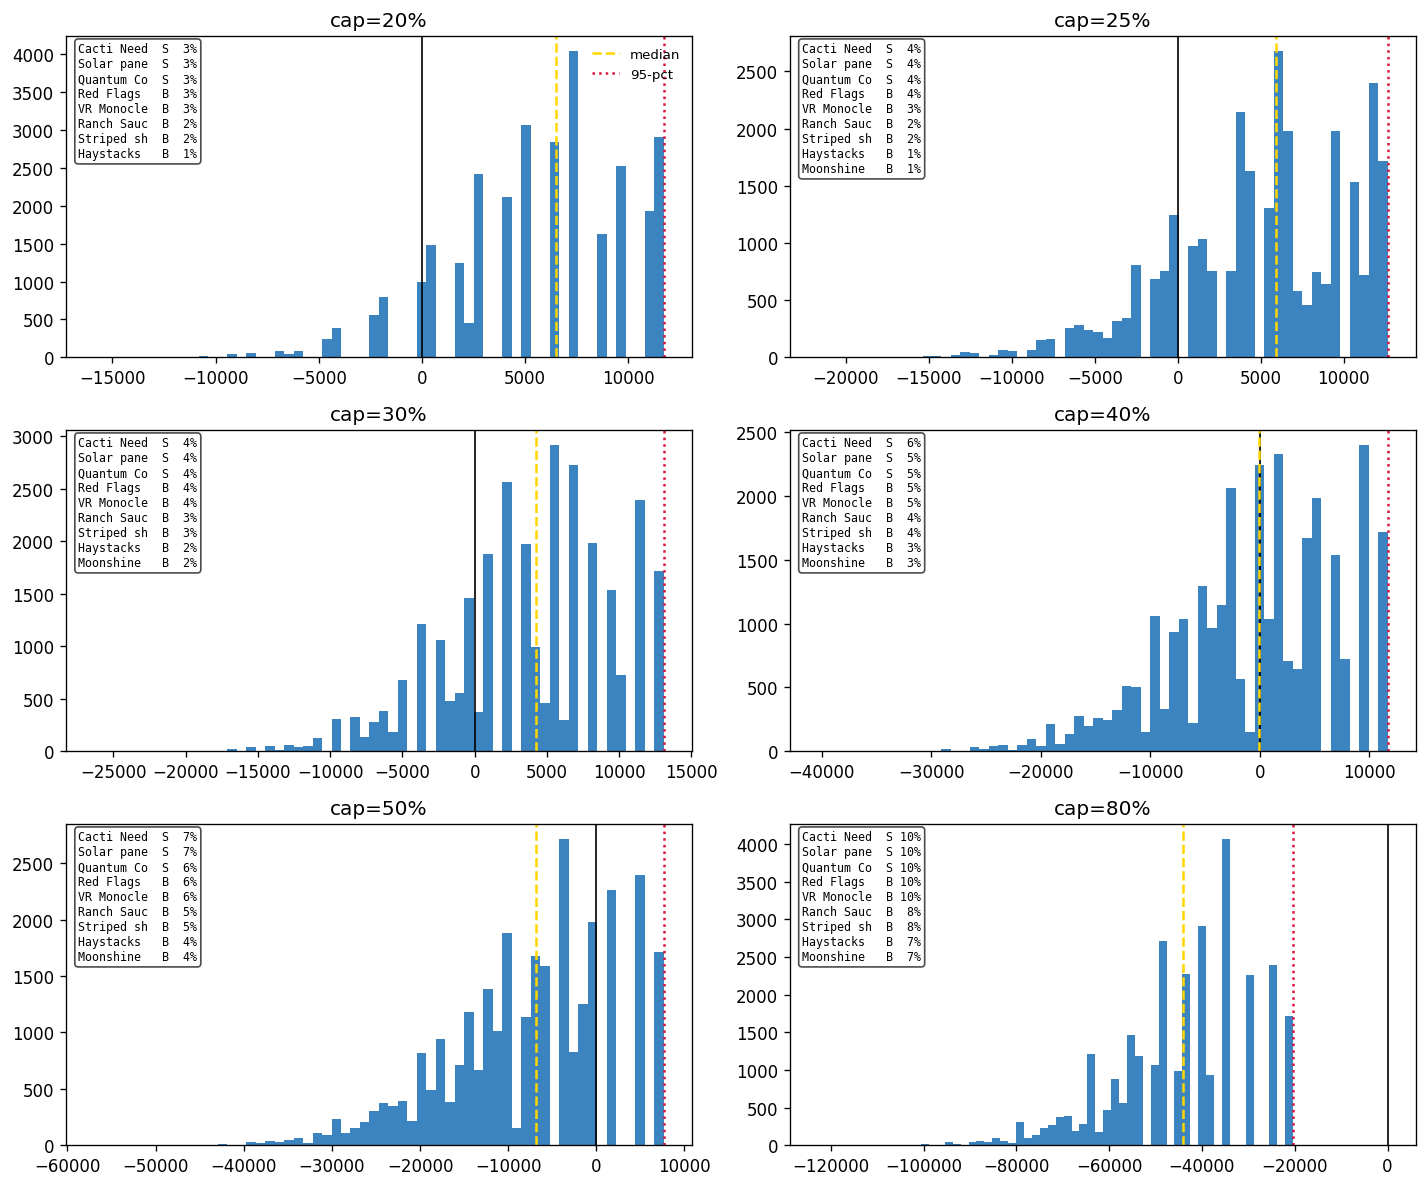

In [5]:
# ---------------- Data -----------------
goods  = ["Cacti Needle","Solar panels","Quantum Coffee",
          "Red Flags","VR Monocle",
          "Ranch Sauce","Striped shirts","Haystacks","Moonshine"]
scores = np.array([-3,-3,-3, 3,3, 2,2, 1,1])

pars = { 3:dict(p=.8,up=.10,down=-.05,sigma=.10),
         2:dict(p=.7,up=.07,down=-.04,sigma=.07),
         1:dict(p=.6,up=.04,down=-.03,sigma=.05),
        -1:dict(p=.6,up=-.04,down=.03,sigma=.05),
        -2:dict(p=.7,up=-.07,down=.04,sigma=.07),
        -3:dict(p=.8,up=-.10,down=.05,sigma=.10)}

news = pd.DataFrame({
    "Good": goods,
    "Score": scores
}).assign(
    mu    = lambda d: d.Score.map(lambda s: pars[s]["p"]*pars[s]["up"] + (1-pars[s]["p"])*pars[s]["down"]),
    sigma = lambda d: d.Score.map(lambda s: pars[s]["sigma"])
)

# ---------- quadratic fee optimiser -------------
def to_integer_percent(w_frac, cap):
    target = int(round(cap*100))
    abs100 = target * np.abs(w_frac) / cap
    pct    = np.floor(abs100).astype(int)
    diff   = target - pct.sum()
    if diff:
        order = np.argsort(-(abs100 - pct))
        for k in range(diff):
            pct[order[k % len(w_frac)]] += 1
    return pct * np.sign(w_frac).astype(int)

def optimise_quad(mu, beta, cap=0.25):
    Δ, s = np.abs(mu), np.sign(mu)
    w0 = Δ/(2*beta)
    if w0.sum() <= cap:
        w_cont = s * w0
    else:
        lo, hi = 0.0, Δ.max()
        for _ in range(50):
            mid = 0.5*(lo+hi)
            if np.maximum((Δ-mid)/(2*beta),0).sum() > cap:
                lo = mid
            else:
                hi = mid
        lam = hi
        w_cont = s * np.maximum((Δ-lam)/(2*beta),0)
    pct_int = to_integer_percent(w_cont, cap)
    return pct_int/100

# ---------- MC matrix -----------
N = 30000
rng = np.random.default_rng(42)
p = news.Score.map(lambda s: pars[s]["p"]).to_numpy()
up= news.Score.map(lambda s: pars[s]["up"]).to_numpy()
dn= news.Score.map(lambda s: pars[s]["down"]).to_numpy()
RET = np.where(rng.random((9,N)) < p[:,None], up[:,None], dn[:,None])

beta = 1.2
def mc_pnl(w_frac):
    fee = -beta * 1_000_000 * (w_frac**2).sum()
    return 1_000_000*(w_frac @ RET)+fee

caps = [0.2,0.25,0.3,0.4,0.5,0.8]
results=[]
for cap in caps:
    w = optimise_quad(news.mu.values, beta, cap)
    pnl = mc_pnl(w)
    results.append({
        "cap"   : cap,
        "w"     : w,
        "pnl"   : pnl,
        "median": np.median(pnl),
        "p95"   : np.percentile(pnl, 95)
    })

# ---------- plot -------------
fig,axes=plt.subplots(3,2,figsize=(12,10))
axes=axes.flatten()
for ax, res in zip(axes, results):
    ax.hist(res["pnl"], bins=60, color="#3b84c0")
    
    # ❶ zero‑line (kept)
    ax.axvline(0, color="k", lw=1)

    # ❷ median
    med = np.median(res["pnl"])
    ax.axvline(med, color="gold", lw=1.5, ls="--", label="median")

    # ❸ 95‑th percentile
    p95 = np.percentile(res["pnl"], 95)
    ax.axvline(p95, color="crimson", lw=1.5, ls=":",  label="95‑pct")

    ax.set_title(f"cap={res['cap']:.0%}")
    txt = [f"{g[:10]:11s} {'B' if p>0 else 'S'} {abs(int(round(p*100))):2d}%"
           for g, p in zip(goods, res["w"]) if p != 0]
    ax.text(0.02, 0.98, "\n".join(txt), va="top", ha="left",
            transform=ax.transAxes, fontsize=7, family="monospace",
            bbox=dict(fc="white", alpha=.7, boxstyle="round"))
    
    # show legend only in the first subplot
    if ax is axes[0]:
        ax.legend(frameon=False, loc="upper right", fontsize=8)

plt.tight_layout()

# ---------- summary table ----------
summary=pd.DataFrame({"cap":[f"{r['cap']:.0%}" for r in results],
                      "Median":[f"{r['median']:,.0f}" for r in results],
                      "95‑pct":[f"{r['p95']:,.0f}" for r in results]})

# weight tables each
rows = []
for r in results:
    row = {"Cap": f"{r['cap']:.0%}",
           "Median": f"{r['median']:,.0f}",
           "P95"   : f"{r['p95']:,.0f}"}
    row.update({g: int(round(100*w))              # signed integer %
                for g, w in zip(goods, r["w"])})
    rows.append(row)

report = pd.DataFrame(rows)

print("\nP&L & weight summary by cap\n")
print(report.to_string(index=False))


/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2549743172.py:56: RuntimeWarning: divide by zero encountered in matmul
  return 1_000_000 * (w_frac @ RET) + fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2549743172.py:56: RuntimeWarning: overflow encountered in matmul
  return 1_000_000 * (w_frac @ RET) + fee
/var/folders/0v/df3_t83d64g22q_7qpk64dy00000gn/T/ipykernel_21488/2549743172.py:56: RuntimeWarning: invalid value encountered in matmul
  return 1_000_000 * (w_frac @ RET) + fee


,cap,Median,95‑pct
0,20%,"6,520","11,720"
1,25%,"5,940","12,640"
2,30%,"4,280","13,080"
3,40%,-20,"11,680"
4,50%,"-6,860","7,640"
5,80%,"-44,120","-20,320"


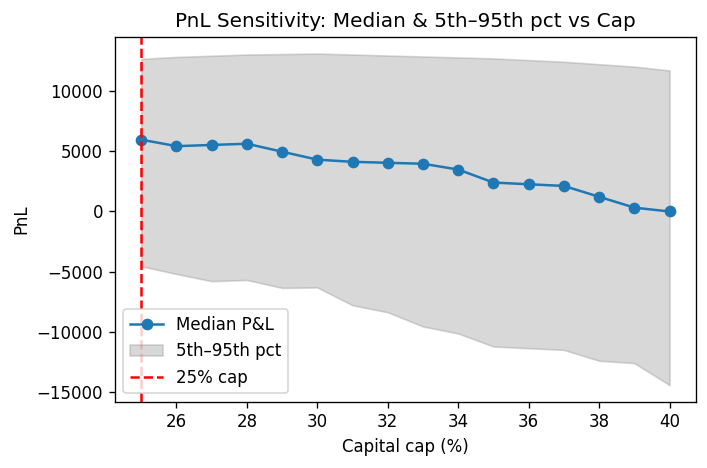

In [10]:
# Sensitivity

# Data + functions re-defined (same as before)
goods = ["Cacti Needle","Solar panels","Quantum Coffee",
         "Red Flags","VR Monocle",
         "Ranch Sauce","Striped shirts","Haystacks","Moonshine"]
scores = np.array([-3,-3,-3, 3,3, 2,2, 1,1])
pars = {
    3: dict(p=0.8, up=0.10, down=-0.05, sigma=0.10),
    2: dict(p=0.7, up=0.07, down=-0.04, sigma=0.07),
    1: dict(p=0.6, up=0.04, down=-0.03, sigma=0.05),
   -1: dict(p=0.6, up=-0.04, down=0.03, sigma=0.05),
   -2: dict(p=0.7, up=-0.07, down=0.04, sigma=0.07),
   -3: dict(p=0.8, up=-0.10, down=0.05, sigma=0.10)
}
news = pd.DataFrame({"Good": goods, "Score": scores}).assign(
    mu=lambda d: d.Score.map(lambda s: pars[s]["p"]*pars[s]["up"] + (1-pars[s]["p"])*pars[s]["down"]),
    sigma=lambda d: d.Score.map(lambda s: pars[s]["sigma"])
)
def to_integer_percent(w_frac, cap):
    target = int(round(cap * 100))
    abs100 = target * np.abs(w_frac) / cap
    pct = np.floor(abs100).astype(int)
    diff = target - pct.sum()
    if diff:
        order = np.argsort(-(abs100 - pct))
        for k in range(diff):
            pct[order[k % len(w_frac)]] += 1
    return pct * np.sign(w_frac).astype(int)
def optimise_quad(mu, beta, cap=0.25):
    Δ, s = np.abs(mu), np.sign(mu)
    w0 = Δ / (2 * beta)
    if w0.sum() <= cap:
        w_cont = s * w0
    else:
        lo, hi = 0.0, Δ.max()
        for _ in range(50):
            mid = 0.5 * (lo + hi)
            if np.maximum((Δ - mid)/(2*beta), 0).sum() > cap:
                lo = mid
            else:
                hi = mid
        lam = hi
        w_cont = s * np.maximum((Δ - lam)/(2*beta), 0)
    pct_int = to_integer_percent(w_cont, cap)
    return pct_int / 100.0
N = 30000
rng = np.random.default_rng(42)
p = news.Score.map(lambda s: pars[s]["p"]).to_numpy()
up = news.Score.map(lambda s: pars[s]["up"]).to_numpy()
dn = news.Score.map(lambda s: pars[s]["down"]).to_numpy()
RET = np.where(rng.random((9, N)) < p[:, None], up[:, None], dn[:, None])
beta = 1.2
def mc_pnl(w_frac):
    fee = -beta * 1_000_000 * (w_frac**2).sum()
    return 1_000_000 * (w_frac @ RET) + fee

# Sensitivity grid
cap_grid = np.arange(0.25, 0.40, 0.01)
results = []
for cap in cap_grid:
    w = optimise_quad(news.mu.values, beta, cap)
    pnl = mc_pnl(w)
    results.append({
        "Cap": f"{int(cap*100)}%",
        "Median": np.median(pnl),
        "P95": np.percentile(pnl, 95),
        "P5": np.percentile(pnl, 5)
    })

summary_df = pd.DataFrame(results)
display(summary)

# Plot with numpy arrays
plt.figure(figsize=(6,4))
x = (cap_grid*100).astype(float)
y_med = summary_df["Median"].values.astype(float)
y5 = summary_df["P5"].values.astype(float)
y95 = summary_df["P95"].values.astype(float)

plt.plot(x, y_med, marker='o', label='Median P&L')
plt.fill_between(x, y5, y95, color='gray', alpha=0.3, label='5th–95th pct')
plt.axvline(25, color='red', ls='--', label='25% cap')
plt.xlabel("Capital cap (%)")
plt.ylabel("PnL")
plt.title("PnL Sensitivity: Median & 5th–95th pct vs Cap")
plt.legend(); plt.tight_layout(); plt.show()

